### End to end train both networks

### Compression network

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Build model with functional api

In [2]:
input_data = Input(shape=(120,), name='input')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

low_dim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(low_dim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



- Define similarity metrics

In [3]:
shape = tf.TensorShape([None,1])

In [4]:
def cos_sim(a_b):
    '''
    a: 120 dim, b:120 dim
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2))
    norm_b = K.sqrt(K.sum(b ** 2))
    
    out = ( K.sum(a * b) / (norm_a * norm_b) )
    
    ####### https://stackoverflow.com/a/37704866/3525373
    out = K.reshape(out, [-1, 1])
    out = tf.placeholder_with_default(out, shape)
    
    return out ### works??
   
    
def funct_shapes(shapes):
    shape1, shape2 = shapes
    return(shape1[0],1)
    
def relative_euc_dist(a_b):
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2))
    norm_a = K.sqrt(K.sum(a ** 2))
    
    out = (norm_diff / norm_a)
    
    out = K.reshape(out, [-1, 1])
    out = tf.placeholder_with_default(out, shape)
    
    return out ### works??


In [5]:
layer_cossim = Lambda(cos_sim, 
                      #output_shape=[low_dim.shape[0], low_dim.shape[1]],  ####### TODO??
                      name='cos_sim')([input_data, decoded])

In [6]:
layer_cossim

<tf.Tensor 'cos_sim/PlaceholderWithDefault:0' shape=(?, 1) dtype=float32>

In [7]:
layer_relativeEuc = Lambda(relative_euc_dist, 
                          # output_shape=(None,1),
                           name='relative_euc_dist')([input_data, decoded])

In [8]:
layer_relativeEuc

<tf.Tensor 'relative_euc_dist/PlaceholderWithDefault:0' shape=(?, 1) dtype=float32>

- Reshape low dim (required???)

In [9]:
def funct_reshape(tensor):
    out = tensor
    out = K.reshape(out, [-1, 1])
    out = tf.placeholder_with_default(out, shape)
    
    return out ### works??


layer_lowdim = Lambda(funct_reshape, name="lowdim_reshape")(low_dim)

In [10]:
layer_lowdim

<tf.Tensor 'lowdim_reshape/PlaceholderWithDefault:0' shape=(?, 1) dtype=float32>

- Obtain "z"

In [11]:
def funct_concat(tensors):
    return K.concatenate(tensors)

#### TODO: none shape????
layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])

In [12]:
layer_concat

<tf.Tensor 'z/concat:0' shape=(?, 3) dtype=float32>

- Construct network (just for testing so far)

In [13]:
compression_net = Model(inputs=input_data, outputs=[layer_concat])

compression_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 120)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 60)           7260        input[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

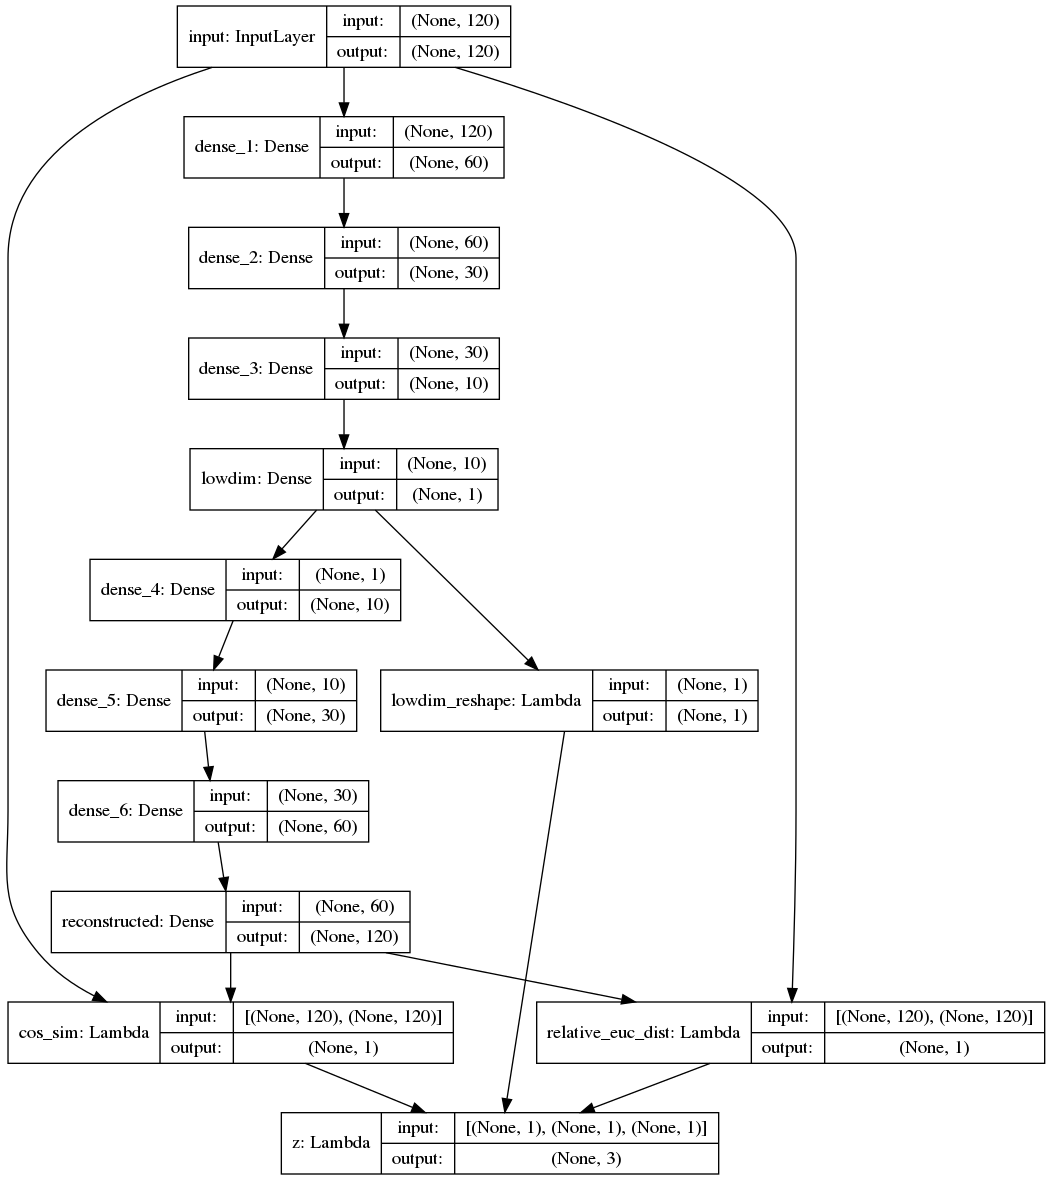

In [14]:
### model visualization
from keras.utils import plot_model


model = compression_net

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

from IPython.display import Image
Image(filename='model.png') 

### Estimation network

In [15]:
input_est = layer_concat #Input(shape=(3,))(layer_concat)

est_layer = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_est)   ####(input_est)
est_layer = Dropout(0.5)(est_layer)
est_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(est_layer)


In [16]:
full_network = Model(input=input_data, outputs=est_output)

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [17]:
full_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 120)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 60)           7260        input[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

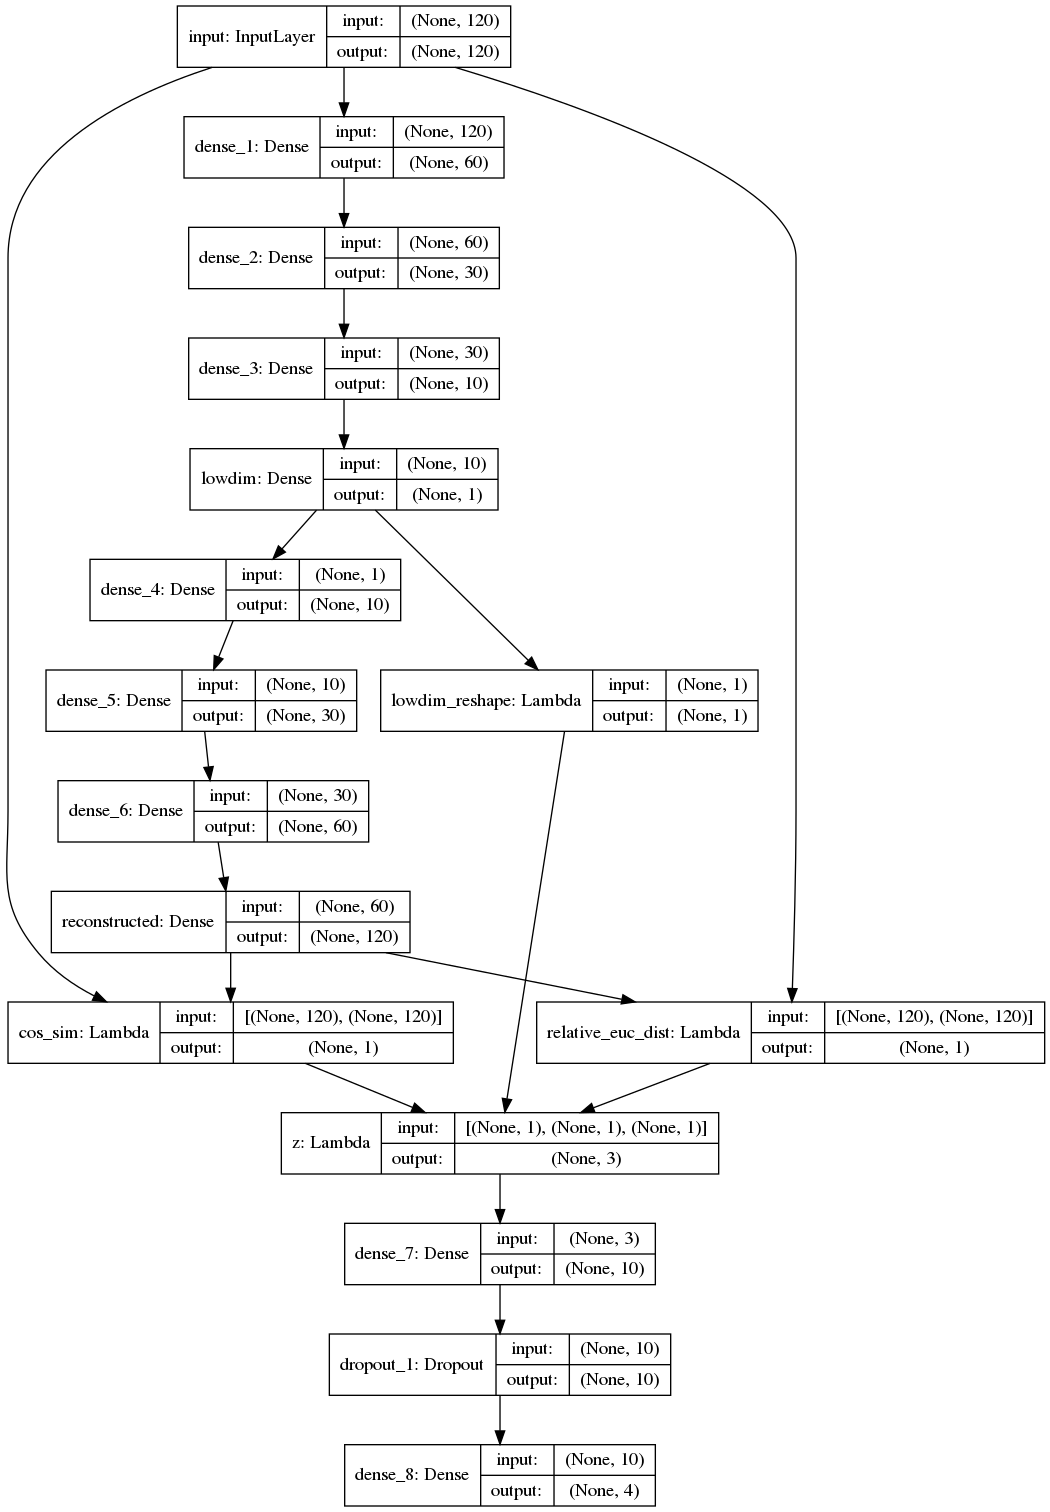

In [18]:
### model visualization
from keras.utils import plot_model


model = full_network

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

from IPython.display import Image
Image(filename='model.png') 

### try training

In [19]:
import numpy as np

### load already saved dataset

In [20]:
with np.load('kdd99_train_test.npz') as data:
    x_train = data['x_train']     
    x_test = data['x_test']

- Get only the normal data     ### TODO: without splits

In [21]:
x_train = x_train[np.where(x_train[:,-1] == 1)]

In [22]:
y_train = np.zeros((len(x_train),4))

y_train[:,0] = 1

In [23]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [24]:
adam = optimizers.adam(lr=0.00005, clipnorm=1., clipvalue=0.5)  # (lr=0.0001)

def l2_loss(yTrue, yPred):
    ### ypred = T.clip(ypred, 0.0001, 0.99999) ###TODO??
    return K.sqrt((yTrue - yPred)**2) 

In [25]:
full_network.compile(optimizer=adam, loss=l2_loss)

In [26]:
### Tensorboard
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M")
print(timestamp, "")

tensorboard = TensorBoard(log_dir='./.logs/compNet+estNet_kdd99/{}'.format(timestamp), 
                            histogram_freq=0, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None)

2018-05-11_14:10 
Instructions for updating:
Use the retry module or similar alternatives.


In [27]:
"""
TODO: only works with batch size 1

"""



history = full_network.fit(x_train, y_train,       ### these details from paper??
               epochs=1,
               batch_size=1,
               shuffle=False,     ### already shuffled with train_test_split
               ##validation_data=(x_test,x_test),
               callbacks=[tensorboard],
               verbose=1)

Epoch 1/1
87538/87538 [==============================] - 556s 6ms/step - loss: 0.0124


In [29]:
### TODO
history = full_network.fit(x_train, y_train,       ### these details from paper??
               epochs=50,
               batch_size=512,
               shuffle=False,     ### already shuffled with train_test_split
               ##validation_data=(x_test,x_test),
               callbacks=[tensorboard],
               verbose=1)

Epoch 1/50


InvalidArgumentError: All dimensions except 1 must match. Input 1 has shape [1 1] and doesn't match input 0 with shape [512 1].
	 [[Node: training/Adam/gradients/z/concat_grad/ConcatOffset = ConcatOffset[N=3, _class=["loc:@z/concat"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/z/concat_grad/mod, training/Adam/gradients/z/concat_grad/ShapeN, training/Adam/gradients/z/concat_grad/ShapeN:1, training/Adam/gradients/z/concat_grad/ShapeN:2)]]
	 [[Node: loss/add_19/_213 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1990_loss/add_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'training/Adam/gradients/z/concat_grad/ConcatOffset', defined at:
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-3bd0751547d4>", line 14, in <module>
    verbose=1)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py", line 1682, in fit
    self._make_train_function()
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/optimizers.py", line 445, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2515, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 488, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 625, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 379, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 625, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py", line 224, in _ConcatGradV2
    op, grad, start_value_index=0, end_value_index=-1, dim_index=-1)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py", line 150, in _ConcatGradHelper
    offset = gen_array_ops.concat_offset(non_neg_concat_dim, sizes)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 880, in concat_offset
    "ConcatOffset", concat_dim=concat_dim, shape=shape, name=name)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'z/concat', defined at:
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 23 identical lines from previous traceback]
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-db73857245ef>", line 5, in <module>
    layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/core.py", line 663, in call
    return self.function(inputs, **arguments)
  File "<ipython-input-11-db73857245ef>", line 2, in funct_concat
    return K.concatenate(tensors)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1881, in concatenate
    return tf.concat([to_dense(x) for x in tensors], axis)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1181, in concat
    return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 949, in concat_v2
    "ConcatV2", values=values, axis=axis, name=name)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): All dimensions except 1 must match. Input 1 has shape [1 1] and doesn't match input 0 with shape [512 1].
	 [[Node: training/Adam/gradients/z/concat_grad/ConcatOffset = ConcatOffset[N=3, _class=["loc:@z/concat"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/z/concat_grad/mod, training/Adam/gradients/z/concat_grad/ShapeN, training/Adam/gradients/z/concat_grad/ShapeN:1, training/Adam/gradients/z/concat_grad/ShapeN:2)]]
	 [[Node: loss/add_19/_213 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1990_loss/add_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
